<a href="https://colab.research.google.com/github/Lydia-HMLin118/chihlee_110_IMS/blob/main/Copy_of_DQN_trader_stage3_0_%E9%A0%90%E6%B8%ACshare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 盤中程式自動交易DQN_測試

交易標的為台指期,模型為DQN, 訓練及測試資料為證交所每五秒交易紀錄資料.目標為DQN模型在盤中依照即時指數變化自動交易(hold,buy,sell),交易後(buy/sell)以Line通知交易價格及數量,並每日彙整交易報表,程式分訓練及測試2部

In [1]:
#!pip install pandas-datareader

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas_datareader as data_reader
import xgboost as xgb
from tqdm import tqdm_notebook, tqdm
from collections import deque
import pickle
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from functools import lru_cache

from datetime import timedelta, date, datetime
import time
import requests
from io import StringIO
from keras.models import load_model
import math
import os

# 測試1:使用訓練時保留的資料測試交易績效

In [4]:
#將訓練時爬下的證交所交易資料讀入
df_crawlered1 = pd.read_csv('/content/gdrive/My Drive/twse_index.csv',index_col=0, dtype={'時間': 'str', '發行量加權股價指數': 'str'}, parse_dates=['時間'])

FileNotFoundError: ignored

In [ ]:
# 去除','並將str轉成float
df_crawlered1['發行量加權股價指數']= list(map(float, [item.replace(',','') for item in df_crawlered1['發行量加權股價指數'] ]))


In [ ]:
#檢查是否有空值
print(df_crawlered1.isnull().sum())


In [ ]:
#參考例:如果需要調整資料口徑可參考
#df_crawlered_10sec =df_crawlered[df_crawlered.index%2 ==0].copy().reset_index(drop=True)

In [ ]:
# 重要參數
window_size = 360 # 依照window_size筆資料(360*5sec約30mins）做預測
batch_size =  64 # 每次DNN模型訓練使用最新64筆memory()
best_episode = 9 # 選擇訓練時最佳的episode
max_inventory = 30 # 設定程式自動買賣最大允許庫存數

In [ ]:
print(df_crawlered1.shape)

In [ ]:
#設定sigmoid函數並使用cache加速
@lru_cache(maxsize=1024)  #增加cache memory
def sigmoid(x): #轉換值介於0-1
  return 1 / (1 + math.exp(-x))


# 設定函數將結果取到小數第二位
def stocks_price_format(n):
  if n < 0:
    return "- $ {0:2f}".format(abs(n))
  else:
    return "$ {0:2f}".format(abs(n))

In [ ]:
df_crawlered = df_crawlered1 
sigmoid_df= df_crawlered['發行量加權股價指數']-df_crawlered['發行量加權股價指數'].shift(1) #取漲跌值
sigmoid_df[0,0]=0
sigmoid_df = sigmoid_df.map(sigmoid)#將漲跌值壓縮在0-1之間

In [ ]:
df_crawlered

In [ ]:
# test的資料切割點
train_ratio = 0.8 #crawlered1_df是訓練時下載的資料集,訓練用了前面80%資料,使用後20%未訓練過的資料
sep_idx = int(df_crawlered.shape[0]*train_ratio) #取切割的index

# 分割出test
df_test = sigmoid_df[sep_idx:].copy().reset_index(drop=True) #取sep_index之後的
actual_price_df = df_crawlered[sep_idx:].copy()['發行量加權股價指數'].values
print(df_test.shape, len(actual_price_df))


In [ ]:
actual_price_df[:5]

In [ ]:
class DQN_trader():
  
  def __init__(self, state_size, best_episode, action_num=3, model_name="DQN_trader"): # state_size=>window_size(360)個壓縮為simoid值的漲跌幅變化來判斷hold,buy,sell)
    self.state_size = state_size
    self.action_num = action_num # number = 3 (有三種action: hold, buy, sell)
    self.memory = deque(maxlen=2000) # que記憶最大2000組
    self.inventory = [] # 設買入庫存紀錄list
    self.model_name = model_name
    self.best_episode = best_episode
    
    self.gamma = 0.618 #用來調整下次reward預測值的重要性
    self.epsilon = 0 # 預測調為0, 訓練時1, 隨機或預測的threshold
    self.epsilon_final = 0.01 # 最低epsilon值
    self.epsilon_decay = 0.995 # 每次epsilon遞減比率: 千分之五
    
    self.model = self.model_dnn()
    
  def model_dnn(self):
    #載入訓練最好的model
    model= load_model(("/content/gdrive/My Drive/DQN股價預測/ai_trader_{}.h5".format(self.best_episode))) 
    
  #  model = tf.keras.models.Sequential()
    
  #  model.add(tf.keras.layers.Dense(units=16, activation='relu', input_dim=self.state_size))
    
  #  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
    
  #  model.add(tf.keras.layers.Dense(units=64, activation='relu'))
    
  #  model.add(tf.keras.layers.Dense(units=128, activation='relu'))
    
  #  model.add(tf.keras.layers.Dense(units=self.action_num, activation='linear'))
    # 最後輸出3個linear值,然後做argmax
  #  model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=1e-3))
    
    return model
  
  def trade(self, state):
    # random or use dnn model to predict action
    
    if random.random() <= self.epsilon: # 進入預測後, epsilon已經設為0,所以不會進入隨機判斷
      return random.randrange(self.action_num)
    
    actions = self.model.predict(state) #predict出三組數字然後argmax產出0,1,2三個數字 #0hold, 1Buy, 2Sell
    return np.argmax(actions[0]) 
  
  @lru_cache(maxsize=1024)
  def batch_train(self, batch_size): 
    
    batch = []
    #取最新64筆memory
    for i in range(len(self.memory) - batch_size + 1, len(self.memory)):
      batch.append(self.memory[i]) # 取出最新batch_size(64)筆memory, 每個memory包含5個items
      
    for state, action, reward, next_state, done in batch: #逐次取出5個items
      reward = reward
      if not done:
        reward = reward + self.gamma * np.amax(self.model.predict(next_state)[0])#引導模型往這次＋預期下次reward方向擬合
        
      target = self.model.predict(state)
      target[0][action] = reward
      
      self.model.fit(state, target, epochs=1, verbose=0) #以過去64筆memory訓練模型來做預測
      
    if self.epsilon > self.epsilon_final: # final值為0.01
      self.epsilon *= self.epsilon_decay # epsilon初始值1, 每次遞減千分之五

In [ ]:
trader = DQN_trader(window_size, best_episode) # window_size用來設定DNN的輸入dimension

In [ ]:
trader.model.summary() # 輸出3個linear數字（訓練時3個數字的y值為環境reward)

In [ ]:
class line_notify():
    
    def __init__(self, api_token, line_token):
        
        self.api_token = api_token
        self.line_token = line_token
        
    def lineNotifyMessage(self, msg):
    
        headers = {
           "Authorization": "Bearer " + self.line_token, 
           "Content-Type" : "application/x-www-form-urlencoded"
       }

        payload = {'message': msg}
        r = requests.post("https://notify-api.line.me/api/notify", headers = headers, params = payload)
        return r.status_code
    
    def buy_sell_notify(self, symbol_id, action , target_price , profit):


        if action == 1:
            self.lineNotifyMessage('重要通知！' + symbol_id + '程式已自動交易[買]了' + str(target_price) + '元\n')

        elif action == 2:
            self.lineNotifyMessage('重要通知！' + symbol_id + '程式已自動交易[賣]了' + str(target_price) + '，獲利：' + str(profit) + '元\n')

        else:
            pass
    
 

In [ ]:
# line_token申請url: https://notify-bot.line.me/zh_TW/
line_token = '這裡請輸入到上面url申請的token'

line = line_notify(line_token= line_token,
                   api_token='自動程式交易通知')

In [ ]:
#測試Line通知功能(需先申請token)
line.buy_sell_notify(symbol_id='台指期TXF10',action=1,target_price=123,profit=123)   

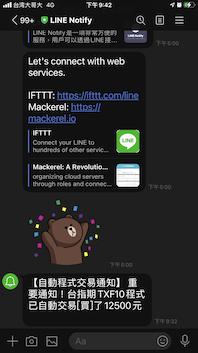

In [ ]:
# the history of buy, sell, profit, inventory, total profit
trading_history=pd.DataFrame(columns = ['代號', '名稱', '1買2賣', '價格', '利潤','剩餘庫存', '利潤加總'])

In [ ]:
learned_memory = pickle.load(open('/content/gdrive/My Drive/DQN股價預測/learned_memory.pkl', 'rb'))

print([x[1] for x in learned_memory]) #概覽learned_memory的0,1,2action分布

In [ ]:
len(learned_memory[0][0][0]) #確認learned_memory的window_size相符

In [ ]:
# predict 
# 以line即時通知交易: 程式自動買入賣出與獲利

# 測試資料
data = df_test.values

# 載入之前memory
learned_memory = pickle.load(open('/content/gdrive/My Drive/DQN股價預測/learned_memory.pkl', 'rb'))  
trader.memory = learned_memory
# 載入memory中最後一個state
state = deque(learned_memory[-1][3][0], maxlen= window_size)
# 產生第一個state
state.append(data[0])

  
#設定初始值
total_profit = 0
buy_count, sell_count = 0, 0
trader.inventory = []
reward = 0


print("====程式開始自動交易====")
for timestep in tqdm(range(1,2000)): #len(data))): # 走test所有資料
  #print(f'timestep is {timestep}')
  curr_state = np.array(state).reshape(-1, window_size) 
  #print(f'curr_state is {curr_state}')
  action = trader.trade(curr_state) # 產出第一個action(非隨機, 是模型預測)
  #print(f'action is {action}')
  state.append(data[timestep])
  next_state = np.array(state).reshape(-1, window_size)
  #print(f'next_state is {next_state}')
  
  
  if action == 1 and len(trader.inventory) < max_inventory: #Buying
    trader.inventory.append(actual_price_df[timestep]) # 在此記入買時價格
    print("DQN Trader bought: ", stocks_price_format(actual_price_df[timestep]))
    buy_count+=1
    #line通知買入及買入價格
    line.buy_sell_notify(symbol_id='台指期TXF10',action=action,target_price=stocks_price_format(data[timestep]),profit=0)
    #['代號', '名稱', '1買2賣', '價格', '利潤','剩餘庫存', '利潤加總']
    trading_history.loc[len(trading_history)]=['TXF10', '台指期10', action, stocks_price_format(actual_price_df[timestep]), 'NaN', len(trader.inventory), total_profit ] 
    
  elif action == 2 and len(trader.inventory) > 0: #Selling
    buy_price = trader.inventory.pop(0)
    sell_count+=1
    reward = max(actual_price_df[timestep] - buy_price, 0) # reward指環境回饋, 最小值為0 
    total_profit += actual_price_df[timestep] - buy_price # 這裡才反應實際賺賠金額
    print("DQN Trader sold: ", stocks_price_format(actual_price_df[timestep]), " Profit: " + stocks_price_format(actual_price_df[timestep] - buy_price) )
    # line通知
    line.buy_sell_notify(symbol_id='台指期TXF10',action=action,target_price=stocks_price_format(data[timestep]),profit=stocks_price_format(data[timestep] - buy_price))
    #['代號', '名稱', '1買2賣', '價格', '利潤','剩餘庫存', '利潤加總']
    trading_history.loc[len(trading_history)]=['TXF10', '台指期10', action, stocks_price_format(actual_price_df[timestep]), stocks_price_format(actual_price_df[timestep] - buy_price), len(trader.inventory) , total_profit] 

  if timestep == len(data)-1: # 跑到最後一筆資料了
    done = True
  else:
    done = False
    
  trader.memory.append((curr_state, action, reward, next_state, done))
  
  
  if done:
    #print("########################")
    print(f"Today's Profit: {total_profit}, Buy: {buy_count}, Sell: {sell_count}, UNSOLD_inventory: {len(trader.inventory)}")
    #print("########################")

  
  if len(trader.memory) > batch_size: # 用最新32個memory訓練DNN
    trader.batch_train(batch_size)

# 存檔交易歷史
trading_history.to_csv('/content/gdrive/My Drive/DQN股價預測/trading_history.csv',encoding='utf-8', index=False )  

# 存檔memory
learned_memory = trader.memory
f = open("/content/gdrive/My Drive/DQN股價預測/test_learned_memory.pkl",'wb')
pickle.dump(learned_memory, f)


In [ ]:
# 程式交易歷史
trading_history

# 測試2:另外下載一天的交易資料做測試自動交易績效

In [ ]:
# 上市指數爬蟲function
# 台灣證交所參考URL: https://www.twse.com.tw/exchangeReport/MI_5MINS_INDEX?response=csv&date=20201019    
def TWSE_INDEX_Crawler(date): # 下載每五秒台股指數資料
    df = pd.DataFrame()
    try:
        url = f'https://www.twse.com.tw/exchangeReport/MI_5MINS_INDEX?response=csv&date={date}'
        res = requests.get(url)
        if res.text != '\r\n':
          df = pd.read_csv(StringIO(res.text.replace('=','')), header=1)
          df = df.loc[0:3240,['時間','發行量加權股價指數' ]]
          df['時間']= date+' '+ df['時間']
          df['時間']=pd.to_datetime(df['時間'])
    except:
        print("failed")
        df = pd.DataFrame()
    time.sleep(5)
    return df

In [ ]:
# 設定爬蟲起止日(視測試需要下載不同日期資料測試)
start_date = '2020-10-27'
end_date  = '2020-10-27'
# 轉換為datetime格式
st_date = datetime.strptime(start_date, "%Y-%m-%d")
ed_date = datetime.strptime(end_date, "%Y-%m-%d")

# 開始爬蟲取得資料
df_crawlered2 = pd.DataFrame(columns=['時間','發行量加權股價指數' ])
while st_date <= ed_date:
  if st_date.weekday() in [0,1,2,3,4]: #週一到週五
    date_str = st_date.strftime("%Y%m%d")
    temp_df = TWSE_INDEX_Crawler(date_str)
    df_crawlered2=df_crawlered2.append(temp_df, ignore_index=True)
  st_date += timedelta(days=1)
df_crawlered2.shape 


In [ ]:
df_crawlered2.to_csv('/content/gdrive/My Drive/twse_index_new.csv')

In [ ]:
#將爬下的證交所交易資料讀入
df_crawlered2 = pd.read_csv('/content/gdrive/My Drive/twse_index_new.csv',index_col=0, dtype={'時間': 'str', '發行量加權股價指數': 'str'}, parse_dates=['時間'])

# 去除','並將str轉成float
df_crawlered2['發行量加權股價指數']= list(map(float, [item.replace(',','') for item in df_crawlered2['發行量加權股價指數'] ]))
df_crawlered2.shape

In [ ]:
df_crawlered = df_crawlered2 
sigmoid_df= df_crawlered['發行量加權股價指數']-df_crawlered['發行量加權股價指數'].shift(1) #取漲跌值
sigmoid_df[0,0]=0
sigmoid_df = sigmoid_df.map(sigmoid)#將漲跌值壓縮在0-1之間
actual_price_df = df_crawlered['發行量加權股價指數'].values

In [ ]:
# 拿來test的資料切割點
train_ratio = 0 # crawlered2_df是上面下載某一天的資料,預計全部拿來測試所以這裡填0
sep_idx = int(df_crawlered.shape[0]*train_ratio) #取切割的index

# 分割出test
df_test = sigmoid_df[sep_idx:].copy()#reset_index(drop=True) #取sep_index之後的
df_test


In [ ]:
trader = DQN_trader(window_size, best_episode) # window_size用來設定DNN的輸入dimension# the history of buy, sell, profit, inventory, total profit
trading_history2=pd.DataFrame(columns = ['代號', '名稱', '1買2賣', '價格', '利潤','剩餘庫存', '利潤加總'])

In [ ]:
# predict 
# 以line即時通知交易: 程式自動買入賣出與獲利

# 測試資料
data = df_test.values

# 載入之前memory
learned_memory = pickle.load(open('/content/gdrive/My Drive/DQN股價預測/learned_memory.pkl', 'rb'))  
trader.memory = learned_memory
# 載入memory中最後一個state
state = deque(learned_memory[-1][3][0], maxlen= window_size)
# 產生第一個state
state.append(data[0])

  
#設定初始值
total_profit = 0
buy_count, sell_count = 0, 0
trader.inventory = []
reward = 0


print("====程式開始自動交易====")
for timestep in tqdm(range(1,len(data))): # 走test所有資料
  curr_state = np.array(state).reshape(-1, window_size) 
  action = trader.trade(curr_state) # 產出第一個action(非隨機, 是模型預測)
  state.append(data[timestep])
  next_state = np.array(state).reshape(-1, window_size)
  
  
  if action == 1 and len(trader.inventory) < max_inventory: #Buying
    trader.inventory.append(actual_price_df[timestep]) # 在此記入買時價格
    #print("DQN Trader bought: ", stocks_price_format(actual_price_df[timestep]))
    buy_count+=1
    #line通知買入及買入價格
    #line.buy_sell_notify(symbol_id='台指期TXF10',action=action,target_price=stocks_price_format(data[timestep]),profit=0)
    #['代號', '名稱', '1買2賣', '價格', '利潤','剩餘庫存', '利潤加總']
    trading_history2.loc[len(trading_history2)]=['TXF10', '台指期', action, stocks_price_format(actual_price_df[timestep]), 'NaN', len(trader.inventory), total_profit ] 
    
  elif action == 2 and len(trader.inventory) > 0: #Selling
    buy_price = trader.inventory.pop(0)
    sell_count+=1
    reward = max(actual_price_df[timestep] - buy_price, 0) # reward指環境回饋, 最小值為0 
    total_profit += actual_price_df[timestep] - buy_price # 這裡才反應實際賺賠金額
    #print("DQN Trader sold: ", stocks_price_format(actual_price_df[timestep]), " Profit: " + stocks_price_format(actual_price_df[timestep] - buy_price) )
    # line通知
    #line.buy_sell_notify(symbol_id='台指期TXF10',action=action,target_price=stocks_price_format(data[t]),profit=stocks_price_format(data[t] - buy_price))
    #['代號', '名稱', '1買2賣', '價格', '利潤','剩餘庫存', '利潤加總']
    trading_history2.loc[len(trading_history2)]=['TXF10', '台指期', action, stocks_price_format(actual_price_df[timestep]), stocks_price_format(actual_price_df[timestep] - buy_price), len(trader.inventory) , total_profit] 

  if timestep == len(data)-1: # 跑到最後一筆資料了
    done = True
  else:
    done = False
    
  trader.memory.append((curr_state, action, reward, next_state, done))
  
  
  if done:
    #print("########################")
    print(f"Today's Profit: {total_profit}, Buy: {buy_count}, Sell: {sell_count}, UNSOLD_inventory: {len(trader.inventory)}")
    #print("########################")

  
  if len(trader.memory) > batch_size: # 用最新64個memory訓練DNN
    trader.batch_train(batch_size)

# 存檔交易歷史
#trading_history2.to_csv('/content/gdrive/My Drive/DQN股價預測/trading_history2.csv',encoding='utf-8', index=False )  

# 存檔memory
#learned_memory = trader.memory
#f = open("/content/gdrive/My Drive/DQN股價預測/test_learned_memory.pkl",'wb')
#pickle.dump(learned_memory, f)


In [ ]:
trading_history2

# 參考資料:元大期貨交易模組

# 取得盤中即時行情
import time
import tailer

#取得當天日期
Date=time.strftime("%Y%m%d")
#設定檔案位置
DataPath="D:/data/"+Date+"/TXFD8/"

#開啟檔案
def MatchFile(Prodid):
　　return(open("/content/gdrive/My Drive/yuanta/"+Date+"/"+Prodid+"/"+Date+'_Match.txt'))

def UpDn5File (Prodid):
　　return(open("/content/gdrive/My Drive/yuanta/"+Date+"/"+Prodid+"/"+Date+'_Match.txt'))

#持續取得成交資訊(QM)
def getMatch(Prodid):
　return tailer.follow(MatchFile(Prodid),0) #second=0

#持續取得上下五檔價資訊(QM)
def getUpDn5(Prodid):
　return tailer.follow(UpDn5File(Prodid),0)

#取得最新一筆成交資訊
def getLastMatch(Prodid):
　return tailer.tail(MatchFile(Prodid),3)[-2].split(",")

#取得最新一筆上下五檔價資訊
def getLastUpDn5(Prodid):
　return tailer.tail(UpDn5File(Prodid),3)[-2].split(",")

# 下單模組
# -*- coding: UTF-8 -*-
#載入相關套件
import subprocess

#下單子程式放置位置
ExecPath = "/content/gdrive/My Drive/yuanta/"

#市價單下單
def OrderMKT(Product,BS,Qty):
　OrderNo=subprocess.check_output([ExecPath+"order.exe",Product,BS,"0",Qty,"MKT",
　　　　　　"IOC","1"]).decode("big5").strip('\r\n')
　time.sleep(0.3)
　return subprocess.check_output([ExecPath+"GetAccount.exe",OrderNo]).decode("big5").strip('\r\n').split(',')[0:2]

#限價單委託
def OrderLMT(Product,BS,Price,Qty):
　OrderNo=subprocess.check_output([ExecPath+"order.exe",Product,BS,Price,Qty,"LMT",
　　　　　　"ROD","0"]).decode("big5").strip('\r\n')
　return OrderNo

#查詢帳務明細
def QueryOrder(OrderID):
　ReturnInfo=subprocess.check_output([ExecPath+"GetAccount.exe",OrderID]).decode("big5").strip('\r\n').split(',')
　return ReturnInfo

#查詢總帳務明細
def QueryAllOrder():
　ReturnInfo=subprocess.check_output([ExecPath+"GetAccount.exe","ALL"]).decode("big5").strip('\r\n').split('\n')
　ReturnInfo= [ line.split(',') for line in ReturnInfo]
　return ReturnInfo

#查詢未平倉資訊
def QueryOnOpen():
　ReturnInfo=subprocess.check_output([ExecPath+"OnOpenInterest.exe"]).decode("big5").strip('\r\n')
　return ReturnInfo.split(',')

#查詢權益數資訊
def QueryRight():
　ReturnInfo=subprocess.check_output([ExecPath+"FutureRights.exe"]).decode("big5").strip('\r\n')
　return ReturnInfo.split(',')

#取消委託
def CancelOrder(OrderID):
　ReturnInfo=subprocess.check_output([ExecPath+"order.exe","Delete",OrderID]).decode("big5")
　if "刪單已傳送" in ReturnInfo:
　　return True
　else:
　　return False

#查看所有未取消委託
def QueryAllUnfinished():
　ReturnInfo = subprocess.check_output([ExecPath+'GetUnfinished.exe']).decode("big5").strip('\r\n')
　return ReturnInfo

#取消所有委託
def CancelAll():
　ReturnInfo = subprocess.check_output([ExecPath+'CancelALL.exe']).decode("big5").strip('\r\n')
　return ReturnInfo

#限價轉刪單
def LMT2DEL(Product,BS,Price,Qty,Sec):
　OrderID=OrderLMT(Product,BS,Price,Qty).decode("big5")
　StartTime=time.time()
　while time.time()-StartTime<Sec:
　　ReturnInfo=QueryOrder(OrderID)[1]
　　if ReturnInfo == '全部成交':
　　　return ReturnInfo
　CancelOrder(OrderID)
　return False

#限價轉市價
def LMT2MKT(Product,BS,Price,Qty,Sec):
　OrderID=OrderLMT(Product,BS,Price,Qty)
　StartTime=time.time()
　while time.time()-StartTime<Sec:
　　ReturnInfo=QueryOrder(OrderID)[1]
　　if ReturnInfo == '全部成交':
　　　return ReturnInfo
　if CancelOrder(OrderID):
　　ReturnInfo=OrderMKT(Product,BS,Qty)
　　return ReturnInfo

## 進場
# 參數設定
currDate = datetime.now().strftime('%Y-%m-%d')
startTime = datetime.strptime(currDate +' '+ startTime,'%Y-%m-%d %H:%M:%S.%f')
endTime = datetime.strptime(currDate +' '+ endTime,'%Y-%m-%d %H:%M:%S.%f')
outTime = datetime.strptime(currDate +' '+ outTime,'%Y-%m-%d %H:%M:%S.%f')

#### 定義變數 & 初始化 ####
print("Initialize......")
Date=time.strftime("%Y%m%d")
code = "TXF10"
TXF_MatchPrice = ""
TXF_MatchTime = ""
BPrice = ""
SPrice = ""
BTime = ""
STime = ""

BorS = ''
position = 0
TradingRecord = pd.DataFrame(columns=['BorS','OpenPrice','ClosePrice','OpenTime','CloseTime','Profit'])
SingleRecord = pd.DataFrame(columns=['BorS','OpenPrice','ClosePrice','OpenTime','CloseTime','Profit'])
profit = 0

high = 0
low = math.inf
spread = 0

#設定 單筆下單口數 & 最大在倉口數
lot = 1
Maxlot = 10

for Mdata in getMatch(code):

　　## 取得最新報價
　　currDate = datetime.now().strftime('%Y-%m-%d')
　　TXF_MatchTime = datetime.strptime(currDate + " " + Mdata.split(",")[1],"%Y-%m-%d %H:%M:%S.%f")
　　TXF_MatchPrice = Mdata.split(",")[2]
　　#print(TXF_MatchTime)
　　#print(TXF_MatchPrice)

　　## 買入
　　if( startTime < TXF_MatchTime < endTime):
　　　　if( action == 1 ):

　　　　　　OrderMKT(code,"B",str(lot))
　　　　　　BorS = "B"
　　　　　　BPrice = TXF_MatchPrice
　　　　　　BTime = TXF_MatchTime
　　　　　　position = position + lot
　　　　　　print("Buy "+ code +" | Buy Price: "+ TXF_MatchPrice +" | Time: "+ datetime.now().strftime('%Y/%m/%d %H:%M:%S'))

　　## 買出
　　elif( ation == 2):

　　　　　　OrderMKT(code,"S",str(lot))
　　　　　　BorS = "S"
　　　　　　SPrice = TXF_MatchPrice
　　　　　　STime = TXF_MatchTime
　　　　　　position = position - lot
　　　　　　print("Sell "+ code +" | Sell Price: "+ TXF_MatchPrice +" | Time: "+ datetime.now().strftime('%Y/%m/%d %H:%M:%S'))
　　else:
　　　　break
　　## 最大口數限制
　　if abs(position) >= Maxlot : break